# 机器学习作业:层次聚类
- 姓名：卢麒萱
- 学号：2010519
- 专业：计算机科学与技术

### 实验要求
#### 基本要求：
a) 实现single-linkage层次聚类算法； 

b) 实现complete-linkage层次聚类算法；

#### 中级要求：
a) 实现average-linkage层次聚类算法； 

b) 将上述三种算法的性能进行简要对比；

#### 高级要求：
通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析；

#### 实验重点函数说明

```
1.create_sample(mean, cov, num, label)

  #生成样本均值向量为mean，协方差矩阵为cov的，数量为num，标签为label的数据集

2.PoMinkowski(x1,x2,dimension,p=2)

  #两样本点之间Minkowski距离，dimension表示样本的特征维数，p=2时，计算的是欧氏距离

3.clusingle(clu1,clu2,dimension,p=2)

  #最短距离/单连接 (single linkage)

4.clucomplete(clu1,clu2,dimension,p=2)

  #最⻓距离/全连接 (complete linkage)

5.cluaverage(clu1,clu2,dimension,p=2)

  #平均距离 (average linkage)

6.discluster(cluster,dimension,kind=0,p=2)

  #类距离矩阵的生成,kind表示使用3,4,5中的哪种方法生成类距离矩阵

7.dismin(distance)

  #根据类距离矩阵确定距离最近的两个类

8.update(cluster,res)

  #更新类，将cluster中的res编号的两个类合并

9.datastat(cluster)

  #数据统计，统计合并完成后生成的三个类的数据

10.aggregation(cluster,dimension,kind=0,p=2)

  #聚合操作

11.makeplt3D(List)

  #根据List绘制三维点空间分布图

12.makeplt2D(List,label1)

  #根据List和label绘制分布直方图
```

#### 代码详解

In [38]:
import numpy as np
import math
import copy
import random
import matplotlib.pyplot as plt
import string

- 生成随机数据

使用`np.random.multivariate_normal`函数生成均值向量为`mean`，协方差矩阵为`cov`，数量为`num`，标签为`label`的样本数据。

In [39]:
# 生成数据
def create_sample(mean, cov, num, label):
    '''
    :param mean: 均值向量
    :param cov: 协方差矩阵
    :param num: 数量
    :param label: 标签
    :return: 最终生成的数据前三列表示特征，后一列表示便签
    '''
    x,y,z=np.random.multivariate_normal(mean,cov,num).T
    L = np.ones(num)*label
    X=np.array([x,y,z,L])
    return X.T

- 两点之间距离计算

在本次试验中使用闵可夫斯基距离进行计算，默认使用`p=2`，即计算两个点之间的欧氏距离

In [40]:
def PoMinkowski(x1,x2,dimension,p=2):
    '''
    :param x1: 点x1
    :param x2: 点x2
    :param dimension: 两个点所在的空间维度
    :param p: 参数p=2时为欧氏距离
    :return: 距离
    '''
    dis = 0
    for i in range(dimension):
        dis = dis + math.pow(x1[i]-x2[i],p)
    return math.sqrt(dis)

- 三种层次聚类算法(基本要求和中级要求)

使用三种不同的方法(如上图)计算两个类之间的距离，类中两个点之间的距离还是使用欧式距离

In [41]:
# 最短距离single linkage
def clusingle(clu1,clu2,dimension,p=2):

    Min = float("inf")
    for i in range(len(clu1)):
        for j in range(len(clu2)):
            d=PoMinkowski(clu1[i],clu2[j],dimension,p)
            Min = d if d < Min else Min
    return Min

# 最长距离complete linkage
def clucomplete(clu1,clu2,dimension,p=2):

    Max = float("-inf")
    for i in range(len(clu1)):
        for j in range(len(clu2)):
            d = PoMinkowski(clu1[i],clu2[j],dimension,p)
            Max = d if d>Max else Max
    return Max

# 平均距离average linkage
def cluaverage(clu1,clu2,dimension,p=2):
    
    d = 0
    for i in range(len(clu1)):
        for j in range(len(clu2)):
            d = d + PoMinkowski(clu1[i],clu2[j],dimension,p)
    ans = d/(len(clu1)*len(clu2))
    return ans


- 生成类距离矩阵

kind表示使用哪一种层次聚类方法，定义`func`为函数指针，`templist[i][j]`表示第`i`个类和第`j`个类的距离。

In [42]:
# 类距离矩阵生成
def discluster(cluster,dimension,kind=0,p=2):
    '''
    :param cluster: 类组成的集合
    :param dimension: 点的维度
    :param p: p=2 表示欧式距离
    :param kind: 使用哪种方法求类距离
    :return: 类距离矩阵
    '''
    if kind == 0:
        func = clusingle
    elif kind == 1:
        func = clucomplete
    elif kind == 2:
        func = cluaverage
    else:
        print("para:'kind' error")
        exit(0)

    templist = np.zeros((len(cluster),len(cluster)))
    for i in range(len(cluster)):
        for j in range(len(cluster)):
            templist[i][j]=func(cluster[i],cluster[j],dimension,p)
    return templist

- 找到距离最近的两个类的下标，便于后面的合并

当i=j时表示的是类和自身的距离，始终为零，当`i=j`时不需要合并，所以排除`j=i`的情况，当迭代过类距离矩阵之后，`res`中储存的是距离最小的两个类的编号

In [43]:
# 找到类集合中距离最近的两个类
def dismin(distance):
    '''
    :param distance: 类距离矩阵
    :return: 距离最近的两个类的坐标
    '''
    Min = float("inf")
    res=[0,0]
    for  i in range(len(distance)):
        for j in range(len(distance)):
            if i!=j and distance[i][j] < Min:
                Min = distance[i][j]
                res = [i,j]
    return res

- 合并两个类

使用`extend`将`b`合并到`a`中，使用`remove`从`cluster`中移除`b`，实现`a`和`b`的合并

In [44]:
# 聚合操作，更新类
def update(cluster,res):
    a = cluster[res[0]]
    b = cluster[res[1]]
    a.extend(b)
    cluster.remove(b)

- 数据统计

统计合并之后每一类中不同类标签的数量储存在`count`中，`count[0][2]`表示`cluster[0]`中类标签为3的样本数量，列表`label`中储存合并后每一类是什么标签(根据这一类中最多的类标签)，`label[0]`储存着`cluster[0]`是哪一类

In [45]:
# 数据统计
def datastat(cluster):
    '''
    :param cluster: 合并之后的类
    :return: count 统计结果 label三类的标签
    '''
    # count统计合并聚类后的三个类中分别含有三种类别样本集合的数量
    count = [[0,0,0],[0,0,0],[0,0,0]]
    for i in range(3):
        for j in range(len(cluster[i])):
            count[i][int(cluster[i][j][3]-1)]+=1
    count=np.array(count)
    # 数量最多的类作为合并后这一类的类标签
    label = count.argmax(axis=1)+1
    return count,label

- 聚合聚类

In [46]:
# 聚合聚类
def aggregation(cluster,dimension,kind=0,p=2):
    '''
    :param cluster: 样本空间
    :param dimension: 维度
    :param kind: 求类距离的方法
    :param p: 欧氏距离
    :return: 聚合后的样本空间
    '''
    i = 0
    # 当类的个数多与3时合并继续
    while(len(cluster)>3):
        # 每一次迭代都重新产生类距离矩阵
        distance = discluster(cluster, dimension, kind, p)
        # 求出距离最近的两个类的下标
        res = dismin(distance)
        # 合并两个类
        update(cluster,res)

- 绘图

In [47]:
# 绘制三维空间分布图
def makeplt3D(List):
    point = np.array(List)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')

    n=len(point)
    #print(n)
    clu = []
    for i in range(3):
        clu.append(list(point[point[:,3]==i+1]))
    #print(clu)

    # symbol中储存点的形状和颜色等
    symbol = [['r','o'],['b','^'],['g','p']]
    for i in range(3):
        temp=[list(c) for c in clu[i]]
        temp=np.array(temp)
        x = temp[:,0]
        y = temp[:,1]
        z = temp[:,2]
        ax.scatter(x,y,z,c=symbol[i][0],marker=symbol[i][1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# 绘制分布直方图
def makeplt2D(List1,label1):
    plt.bar([0.6, 1.7, 2.7], List1[0], width=0.2, label=str(label1[0]))
    plt.bar([1, 2, 3], List1[1], width=0.2, label=str(label1[1]))
    plt.bar([1.3, 2.3, 3.3], List1[2], width=0.2, label=str(label1[2]))

    plt.legend()
    plt.xlabel('predict class')
    plt.ylabel('quantity')
    plt.title(u'Quantity Bar Chart')

    plt.show()

- 主体函数

总共产生了102个样本
使用single-linkage层次聚类算法
cluster[0]标签为2
cluster[1]标签为3
cluster[2]标签为1
每一类的构成及错误率如下:
cluster	类	类1	类2	类3	错误率

   0 	 2	33	34	33	0.6599999999999999
   1 	 3	0	0	1	0.0
   2 	 1	1	0	0	0.0
综上:总的错误率为0.6470588235294117
使用complete-linkage层次聚类算法
cluster[0]标签为1
cluster[1]标签为3
cluster[2]标签为2
每一类的构成及错误率如下:
cluster	类	类1	类2	类3	错误率

   0 	 1	27	3	0	0.09999999999999998
   1 	 3	1	9	32	0.23809523809523814
   2 	 2	6	22	2	0.2666666666666667
综上:总的错误率为0.20588235294117652


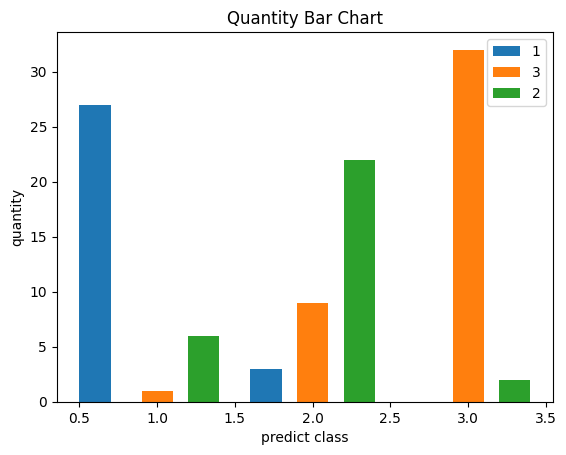

使用average-linkage层次聚类算法
cluster[0]标签为1
cluster[1]标签为3
cluster[2]标签为3
每一类的构成及错误率如下:
cluster	类	类1	类2	类3	错误率

   0 	 1	33	20	2	0.4
   1 	 3	1	14	31	0.32608695652173914
   2 	 3	0	0	1	0.0
综上:总的错误率为0.36274509803921573


In [65]:
if __name__ == "__main__":
    # 参数设置
    mean = np.array([[1,1,1],[2,2,2],[3,3,3]])
    cov = [[0.5,0,0],[0,0.5,0],[0,0,0.5]]
    n = 102
    P = 1/3
    num = [round(n*P) for i in range(3)]
    total = 0
    # clus储存合并后的矩阵
    clus1 = []
    # 数据生成并集合
    for i in range(3):
        total += num[i]
        clus1.extend(create_sample(mean[i],cov,num[i],i+1))
    # 将矩阵转为类
    clus=[[list(c)] for c in clus1]
    print("总共产生了{}个样本".format(total))
    str1 = ["single","complete","average"]

    for k in range(3):
        cor = 0
        # 深拷贝
        cluster = copy.deepcopy(clus)
        # 打乱顺序(没什么用)
        random.shuffle(cluster)
        # 聚合聚类
        aggregation(cluster,3,k)
        # string中储存了三个字符串
        print("使用{}-linkage层次聚类算法".format(str1[k]))
        # 返回统计信息
        count, label = datastat(cluster)
        
        # 输出每一种层次聚类方法的统计信息
        for i in range(3):
            print("cluster[{}]标签为{}".format(i,label[i]))
        print("每一类的构成及错误率如下:")
        print("cluster\t类\t类1\t类2\t类3\t错误率\n")
        for i in range(3):
            print("  ",i,"\t",label[i],end="")
            for j in range(3):
                print("\t{}".format(count[i][j],j+1),end="")
            cor += count[i][label[i]-1]
            print("\t{}\n".format(1-count[i][label[i]-1]/sum(count[i])),end="")
        print("综上:总的错误率为{}".format(1-cor/total))
        if k == 1:
            makeplt2D(count, label)

#### 实验结果

(在这里使用不同的协方差矩阵进行对比分析)

(1) 实现`single-linkage`层次聚类算法

(2) 实现`complete-linkage`层次聚类算法

(3) 实现`average-linkage`层次聚类算法

在这里使用生成102个样本(2000个样本运行太慢)

> 当协方差矩阵为[[5, 0, 0], [0, 5, 0], [0, 0, 5]]时:

![图片](1.png)

当协方差为5时，三种类别的层次聚类算法的错误率都很高，都到了`50%`以上，而且我们发现此时的样本聚类都是聚集在某一类中，PS:我们的数据集中三类数据是平均产生的，相比较而言，此时的`average-linkage`层次聚类算法的性能比较好。

> 当协方差矩阵为[[0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5]]时:

![图片](2.png)

当协方差为0.5时，`single`和`average`算法仍然出现了严重的分类不均问题。`single-linkage`算法的错误率并没有明显的下降，仍然为`65%`上下，`complete-linkage`算法下降为了`21.5%`，`average-link`算法的错误率下降为了`36.2%`，此时性能最好的仍然是`complete-link`层次聚类算法

> 当协方差矩阵为[[0.05, 0, 0], [0, 0.05, 0], [0, 0, 0.05]]时

![图片](3.png)

当协方差为0.05时，三者的分类准确率均为100%，没有可比性，因为当协方差为0.05时，三类数据都是泾渭分明的，如下图：

![图片](4.png)

(4) 绘图聚类前后样本分布情况

> 聚类前后样本点在空间中的位置并没有改变(以协方差为0.5为例)，如下图:

![图片](5.png)

> 聚类后三类的分布直方图(以协方差=0.5为例)如下:

![图片](6.png)

此时数据如下：

![图片](7.png)